# Class attention on random inputs, multibatch

## FROZEN, DO NOT MODIFY

Same as `02_random_model.ipynb`, but now different batches have different possible classes

In [1]:
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
def detorch(x):
    return x.detach().cpu().numpy()

In [3]:
input_size = 7
hidden_size = 11
n_classes = 5
batch_size = 3

In [4]:
class ClassAttentionModel(nn.Module):
    def __init__(self,):
        super().__init__()

        self.x_enc = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

        self.c_enc = nn.Embedding(n_classes, hidden_size)

    def forward(self, x, c):
        h_x = self.x_enc(x)
        h_c = self.c_enc(c)
        
        logits = h_x @ h_c.T

        return logits


class ClassAttentionWNet(nn.Module):
    def __init__(self,):
        super().__init__()

        self.x_enc = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

        self.c_enc = nn.Sequential(nn.Embedding(n_classes, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

    def forward(self, x, c):
        h_x = self.x_enc(x)
        h_c = self.c_enc(c)

        logits = h_x @ h_c.T # + bias  # or make a residual connection with class network

        return logits

class ClassAttentionWNetWBias(nn.Module):
    def __init__(self,):
        super().__init__()

        self.x_enc = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

        self.c_enc = nn.Sequential(nn.Embedding(n_classes, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))
        self.c_bias = nn.Embedding(n_classes, hidden_size)

    def forward(self, x, c):
        h_x = self.x_enc(x)
        h_c = self.c_enc(c)
        b_c = self.c_bias(c)
        
        logits = h_x @ h_c.T + b_c.T

        return logits


### Notes

* Residual is both not possible and does not increase capacity (it is just a reparametrization of the network)
* Class bias is just a reparametrization of class network
  * `h_x @ h_c.T + b_c(c)` is not possible as class network does not know the batch size
* While input bias will need to know the number of classes upfront and will be the same as having a regular logits layer
  * `h_x` + Identity is not possible as h_x is not a square matrix


In [5]:
possible_classes = [f'Class {str(i)}' for i in range(n_classes)]
label2c = {possible_classes[i]: i for i in range(len(possible_classes))}
c = torch.LongTensor([label2c[l] for l in possible_classes])

print("Possible labels: ", possible_classes)
print("Label2c        : ", label2c)
print("c              : ", c)

Possible labels:  ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
Label2c        :  {'Class 0': 0, 'Class 1': 1, 'Class 2': 2, 'Class 3': 3, 'Class 4': 4}
c              :  tensor([0, 1, 2, 3, 4])


## Batches

In [6]:
n_batches = 10

xs = [torch.randn([batch_size, input_size]) for _ in range(n_batches)]

y_strs = [random.choices(possible_classes, k=batch_size) for _ in range(n_batches)]
# y != f(y_str),
# y == f(y_str, possible_classes, batch)
ys = [torch.LongTensor([label2c[s] for s in y_str]) for y_str in y_strs]


print("X: ", xs)
print("Labels         : ", y_strs)
print("Labels Tensor  : ", ys)

X:  [tensor([[-1.0640, -0.1658, -0.3808,  0.3632, -2.0793, -1.2112,  0.1707],
        [-0.9026, -0.5721, -0.2616, -1.1414,  0.7579, -1.0588, -0.2307],
        [-0.3293,  0.1335, -1.1441, -0.3670, -1.8501,  2.1329,  0.0661]]), tensor([[ 1.6063, -0.4739,  0.4910,  0.4854, -0.8770,  0.4760, -0.0511],
        [-0.7954,  0.8506,  0.4274,  0.3784, -0.9543,  1.8191,  0.7224],
        [-0.1351, -0.2909,  0.8673,  2.0044, -0.7073,  0.3140, -1.1545]]), tensor([[ 0.2522,  0.1646, -1.8822,  0.7542, -0.1643,  0.0591, -0.5001],
        [-0.3465, -0.5268,  1.5732,  1.4789, -0.5040,  1.9792, -0.4260],
        [-0.3964,  1.4608,  1.3260,  2.0371, -0.3690, -0.8664, -1.0025]]), tensor([[ 0.9810,  0.5489, -0.5276,  0.1313,  0.7238,  1.4043,  0.2396],
        [ 0.6387, -0.1497, -1.7163, -2.0002, -1.0724, -0.7336,  1.3686],
        [ 0.4706, -0.4744,  1.2886, -0.3487, -0.5496,  0.2500, -0.9966]]), tensor([[-0.5078, -0.7030,  1.6001, -0.9710,  0.5509, -0.8885,  1.4050],
        [ 0.6510,  1.0953, -0.2433,  1

In [7]:
class LabelEncoder:
    """
    Numericalizes batches of labels given possible labels, also returns targets tensor that can be used to compute loss.

    Args:
        all_classes: list[str], text description of the classes (e.g., class names)

    Usage:
        label_encoder = LabelEncoder(['Weather', 'News', 'Music', 'Sport'])

        classes_str = ['News', 'Weather', 'Weather', 'News']
        possible_classes = ['Weather', 'News', 'Sport']

        possible_class_ids, targets = label_encoder.encode(classes_str, possible_classes)
        # possible_class_ids: [0, 1, 2]
        # targets: [1, 2, 2, 1]

        logits = net(text_ids, possible_class_ids)
        loss = F.cross_entropy(logits, targets)
    """
    def __init__(self, all_classes):
        self._classes_set = set(all_classes)
        self._id2label = all_classes
        self._label2id = {l: i for i, l in enumerate(self._id2label)}

    @property
    def possible_classes(self):
        return self._id2label

    def encode(self, classes_str, possible_classes):
        """
        Args:
            classes_str: list[str] of size batch_size, class descriptions that need to be encoded 
            possible_classes: list[str] of size n_classes, a subset of self.possible_classes - all possible classes for current batch
        
        Returns:
            tuple(label_ids, target) where
                label_ids: torch.LongTensor[n_classes] label ids of the possible classes, fed to the label encoder
                target: torch.LongTensor[batch_size] of targets that use possible_classes for ordering,
                    used for loss computation
        
        """
        if not set(possible_classes).issubset(self._classes_set):
            raise ValueError(f"possible_classes {possible_classes} containes classes not from the LabelEncoder .possible_classes")

        if not set(classes_str).issubset(self._classes_set):
            raise ValueError(f"classes_str {classes_str} containes classes not from the LabelEncoder .possible_classes")

        label_str_ids = torch.LongTensor([self._label2id[l] for l in possible_classes])

        label2target = {l: i for i, l in enumerate(possible_classes)}
        target = torch.LongTensor([label2target[l] for l in classes_str])

        return label_str_ids, target

    def decode_label_ids(self, label_str_ids):
        return [self._id2label[i] for i in label_str_ids]

    def decode_target(self, target, possible_classes):
        return [possible_classes[t] for t in target]


label_encoder = LabelEncoder(possible_classes)
y_str = y_strs[0]

for shuffle_ in range(2):
    for _possible_classes in [possible_classes,]:

        _possible_classes = copy.copy(_possible_classes)
        random.shuffle(_possible_classes)
        y, targets = label_encoder.encode(y_str, _possible_classes)


        print('Possible labels: \n', _possible_classes)
        print('Str: \n', y_str)
        print('Encoded strs: \n', y)
        print('Targers corresponding to _possible_classes: \n', targets)
        print('Decoded label strings: \n', label_encoder.decode_label_ids(y))
        print('Decoded targets: \n', label_encoder.decode_target(targets, _possible_classes))
        print()

        assert _possible_classes == label_encoder.decode_label_ids(y)
        assert y_str == label_encoder.decode_target(targets, _possible_classes)


Possible labels: 
 ['Class 2', 'Class 1', 'Class 4', 'Class 3', 'Class 0']
Str: 
 ['Class 2', 'Class 2', 'Class 2']
Encoded strs: 
 tensor([2, 1, 4, 3, 0])
Targers corresponding to _possible_classes: 
 tensor([0, 0, 0])
Decoded label strings: 
 ['Class 2', 'Class 1', 'Class 4', 'Class 3', 'Class 0']
Decoded targets: 
 ['Class 2', 'Class 2', 'Class 2']

Possible labels: 
 ['Class 4', 'Class 3', 'Class 1', 'Class 0', 'Class 2']
Str: 
 ['Class 2', 'Class 2', 'Class 2']
Encoded strs: 
 tensor([4, 3, 1, 0, 2])
Targers corresponding to _possible_classes: 
 tensor([4, 4, 4])
Decoded label strings: 
 ['Class 4', 'Class 3', 'Class 1', 'Class 0', 'Class 2']
Decoded targets: 
 ['Class 2', 'Class 2', 'Class 2']



## Train class attention with class embeddings

Text(0.5, 1.0, 'Accuracy')

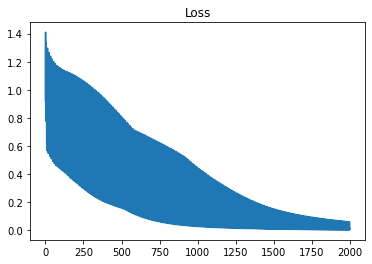

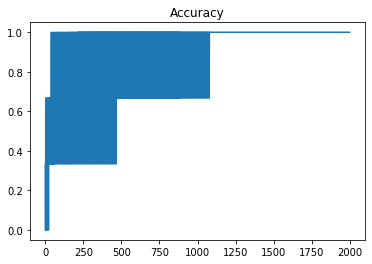

In [12]:
# we definitely have an issue as the model cannot learn two batches perfectly

loss_hist = []
acc_hist = []

label_encoder = LabelEncoder(possible_classes)
model = ClassAttentionModel()
optimizer = torch.optim.Adam(model.parameters())


for _ in tqdm(range(200)):
    for x, y in zip(xs, y_strs):
        optimizer.zero_grad()

        _possible_classes = list(set(y))
        # to check robustness
        random.shuffle(_possible_classes)

        class_str_ids, target = label_encoder.encode(y, _possible_classes)
        assert _possible_classes == label_encoder.decode_label_ids(class_str_ids)
        assert y == label_encoder.decode_target(target, _possible_classes)

        logits = model(x, class_str_ids)  # ERROR: model should eat class_str_ids=f(_possible_classes) != f(_possible_classes, y)

        loss = F.cross_entropy(logits, target)

        _, preds = logits.max(-1)
        acc = torch.sum(preds == target).float() / x.shape[0]

        acc_hist.append(detorch(acc))
        loss_hist.append(detorch(loss))

        loss.backward()
        optimizer.step()


plt.figure()
plt.plot(loss_hist)
plt.title('Loss')

plt.figure()
plt.plot(acc_hist)
plt.title('Accuracy')

## Train class attention with a classs network

Text(0.5, 1.0, 'Accuracy')

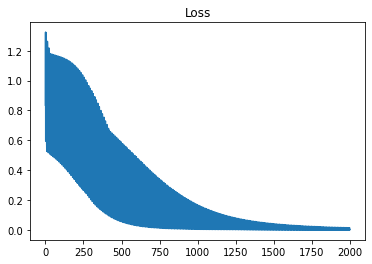

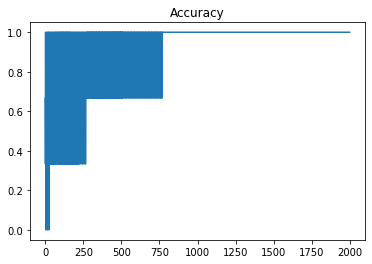

In [15]:
loss_hist = []
acc_hist = []

model = ClassAttentionWNet()
optimizer = torch.optim.Adam(model.parameters())


for _ in tqdm(range(200)):
    for x, y in zip(xs, y_strs):
        optimizer.zero_grad()

        _possible_classes = list(set(y))
        # to check robustness
        random.shuffle(_possible_classes)

        class_str_ids, target = label_encoder.encode(y, _possible_classes)
        assert _possible_classes == label_encoder.decode_label_ids(class_str_ids)
        assert y == label_encoder.decode_target(target, _possible_classes)

        logits = model(x, class_str_ids)  # ERROR: model should eat class_str_ids=f(_possible_classes) != f(_possible_classes, y)

        loss = F.cross_entropy(logits, target)

        _, preds = logits.max(-1)
        acc = torch.sum(preds == target).float() / x.shape[0]

        acc_hist.append(detorch(acc))
        loss_hist.append(detorch(loss))

        loss.backward()
        optimizer.step()


plt.figure()
plt.plot(loss_hist)
plt.title('Loss')

plt.figure()
plt.plot(acc_hist)
plt.title('Accuracy')